# Object Detection in Google Colab with Fizyr Retinanet

Jupyter notebook providing steps to train a Keras/Tensorflow model for object detection with custom dataset.

It runs in Google Colab using [Fizyr implementation](https://github.com/fizyr/keras-retinanet) of RetinaNet in Keras.

Requirements are only dataset images and annotations file made in [LabelImg](https://github.com/tzutalin/labelImg).

Colab Runtime type: Python3, GPU enabled.

# Environment Setup
Download and install in Colab required packages and import libraries.

In [1]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 5705 (delta 28), reused 38 (delta 15), pack-reused 5620
Receiving objects: 100% (5705/5705), 14.07 MiB | 20.33 MiB/s, done.
Resolving deltas: 100% (3798/3798), done.


In [2]:
%cd keras-retinanet/

!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=170876 sha256=18a625e55b55089e5a7dfe9bf4bff6ed54d82d055b8e4591134fa97cc20ac8b2
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13346 sha256=275dd1c4504c1041304b75a228557860d8e59f01f9dce039ccd44a936968d165
  Stored in directory: /root/.cache/pip/wheels/80/dd/ac/842235b63dddac12faa4b48ebe58b8944e8c2e57c2e38dddb6
Successfully built keras-retinanet keras-resnet


In [3]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [0]:
import os
import shutil
import zipfile
import urllib
import xml.etree.ElementTree as ET
import numpy as np
import csv
import pandas
from google.colab import drive
from google.colab import files

# Making Dataset

Download from Drive training dataset, and convert it to Fizyr annotations format.

Before upload in Google Drive a zip file containing annotations and images for training dataset, with following format (check my zip sample):

```
objdet_reduced_dataset.zip
|- img1.jpg
|- img1.xml
|- img2.jpg
|- img2.xml
...
```

Then change accordingly DATASET_DRIVEID.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
DATASET_DRIVEID = '1Iz4rYUWJRXY_UG0VDwMpRAG2Oi8LrvKl'

In [0]:
DATASET_DIR = 'dataset'
ANNOTATIONS_FILE = 'annotations.csv'
CLASSES_FILE = 'classes.csv'

In [8]:
drive_url = 'https://drive.google.com/open?id=1Iz4rYUWJRXY_UG0VDwMpRAG2Oi8LrvKl'
file_name = '1Iz4rYUWJRXY_UG0VDwMpRAG2Oi8LrvKl.zip'

urllib.request.urlretrieve(drive_url, file_name)
print('Download completed!')

os.makedirs(DATASET_DIR, exist_ok=True)
with zipfile.ZipFile('/content/drive/My Drive/Colab Notebooks/objdet_fizyr_colab-master/mask3.zip','r') as zip_ref:
  zip_ref.extractall(DATASET_DIR)
print('Extract completed!')

Download completed!
Extract completed!


In [0]:
annotations = []
classes = set([])

for xml_file in [f for f in os.listdir(DATASET_DIR) if f.endswith(".xml")]:
  tree = ET.parse(os.path.join(DATASET_DIR, xml_file))
  root = tree.getroot()

  file_name = None

  for elem in root:
    if elem.tag == 'filename':
      file_name = os.path.join(DATASET_DIR, elem.text)

    if elem.tag == 'object':
      obj_name = None
      coords = []
      for subelem in elem:
        if subelem.tag == 'name':
          obj_name = subelem.text
        if subelem.tag == 'bndbox':
          for subsubelem in subelem:
            coords.append(subsubelem.text)
      item = [file_name] + coords + [obj_name]
      annotations.append(item)
      classes.add(obj_name)

with open(ANNOTATIONS_FILE, 'w') as f:
  writer = csv.writer(f)
  writer.writerows(annotations)

with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

# Training Model

Download pretrained model and run training.

In the next cell choose one option:

1.   download Fizyr Resnet50 pretrained model
2.   download your custom pretrained model, to continue previous training epochs

In the last cell optionally export trained model to Google Drive.


In [10]:
PRETRAINED_MODEL = './snapshots/_pretrained_model.h5'

####DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
DRIVE_MODEL = '/content/drive/My Drive/Colab Notebooks/objdet_fizyr_colab-master/resnet50_coco_best_v2.1.0.h5'
shutil.copy(DRIVE_MODEL, PRETRAINED_MODEL)


print('Downloaded pretrained model to ' + PRETRAINED_MODEL)

Downloaded pretrained model to ./snapshots/_pretrained_model.h5


# !keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 10 csv annotations.csv classes.csv

In [11]:
!keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 25 csv annotations.csv classes.csv

Using TensorFlow backend.
2020-04-29 14:59:25.985375: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-04-29 14:59:28.217559: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-04-29 14:59:28.264567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-04-29 14:59:28.265151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-04-29 14:59:28.265195: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart

In [0]:
#### OPTIONAL: EXPORT TRAINED MODEL TO DRIVE ####
#drive.mount('/content/gdrive')
#COLAB_MODEL = './snapshots/resnet50_csv_10.h5'
#DRIVE_DIR = '/content/gdrive/My Drive/Colab Notebooks/objdet_tensorflow_colab/'
#shutil.copy(COLAB_MODEL, DRIVE_DIR)
# !keras_retinanet/bin/train.py --freeze-backbone --random-transform --weights {PRETRAINED_MODEL} --batch-size 8 --steps 500 --epochs 30 csv annotations.csv classes.csv

# Inference
Run inference with uploaded image on trained model.

In [0]:
THRES_SCORE = 0.8

In [14]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%reload_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config =  tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.compat.v1.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
tf.compat.v1.keras.backend.set_session(get_session())

Using TensorFlow backend.


In [15]:
model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
print(model_path)

# load retinanet model
model = models.load_model(model_path, backbone_name='resnet50')
model = models.convert_model(model)

# load label to names mapping for visualization purposes
labels_to_names = pandas.read_csv(CLASSES_FILE,header=None).T.loc[0].to_dict()

snapshots/resnet50_csv_25.h5
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-22.627417, -11.313708,  22.627417,  11.313708],
       [-28.50876 , -14.25438 ,  28.50876 ,  14.25438 ],
       [-35.918785, -17.959393,  35.918785,  17.959393],
       [-16.      , -16.      ,  16.      ,  16.      ],
       [-20.158737, -20.158737,  20.158737,  20.158737],
       [-25.398417, -25.398417,  25.398417,  25.398417],
       [-11.313708, -22.627417,  11.313708,  22.627417],
       [-14.25438 , -28.50876 ,  14.25438 ,  28.50876 ],
       [-17.959393, -35.918785,  17.959393,  35.918785]], dtype=float32)> anchors
tracking <tf.Variable 'Variable:0' shape=(9, 4) dtype=float32, numpy=
array([[-45.254833, -22.627417,  45.254833,  22.627417],
       [-57.01752 , -28.50876 ,  57.01752 ,  28.50876 ],
       [-71.83757 , -35.918785,  71.83757 ,  35.918785],
       [-32.      , -32.      ,  32.      ,  32.      ],
       [-40.317474, -40.317474,  40.317474,  40.317474],
       [

In [0]:
def img_inference(img_path):
  image = read_image_bgr(img_infer)

  # copy to draw on
  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  # preprocess image for network
  image = preprocess_image(image)
  image, scale = resize_image(image)

  # process image
  start = time.time()
  boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
  print("processing time: ", time.time() - start)

  # correct for image scale
  boxes /= scale

  # visualize detections
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
      # scores are sorted so we can break
      if score < THRES_SCORE:
          break

      color = label_color(label)

      b = box.astype(int)
      draw_box(draw, b, color=color)

      caption = "{} {:.3f}".format(labels_to_names[label], score)
      draw_caption(draw, b, caption)

  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.imshow(draw)
  plt.show()

Saving img6.jpg to img6.jpg
Running inference on: img6.jpg
processing time:  3.4831173419952393


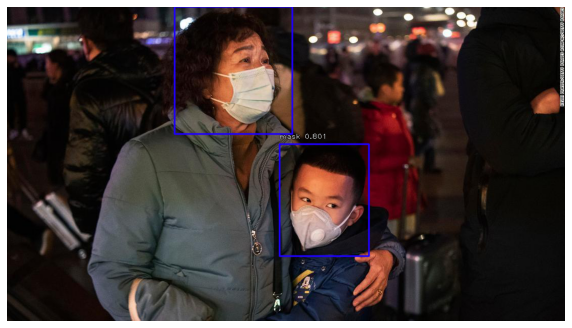

In [18]:
uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)

Saving img605.jpg to img605.jpg
Running inference on: img605.jpg
processing time:  0.12261319160461426


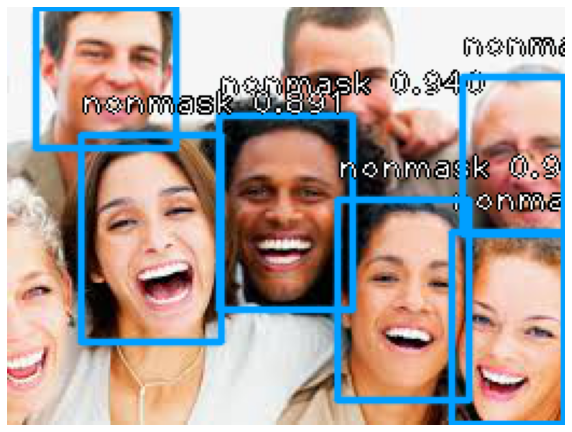

In [32]:
uploaded = files.upload()
img_infer = list(uploaded)[0]

print('Running inference on: ' + img_infer)
img_inference(img_infer)

In [35]:
video_path = '/content/drive/My Drive/Colab Notebooks/objdet_fizyr_colab-master/mask_video.mp4'
output_path = '/content/drive/My Drive/Colab Notebooks/objdet_fizyr_colab-master/mask_output/mask_result.avi'
fps = 20

vcapture = cv2.VideoCapture(video_path)

width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))  # uses given video width and height
height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
vwriter = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'MJPG'),fps, (width, height)) #

num_frames = int(vcapture.get(cv2.CAP_PROP_FRAME_COUNT))
print("Number of Frames: ", num_frames)
print("Original Width, Height: ", width, height)

Number of Frames:  2894
Original Width, Height:  1280 720


In [0]:
def run_detection_video(video_path):
    count = 0
    success = True
    start = time.time()
    while success:
        if count % 100 == 0:
            print("frame: ", count)
        count += 1  # see what frames you are at
        # Read next image
        success, image = vcapture.read()
        
        if success:
            
            # so we can keep orig image scale
            draw = image.copy()
            draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)
            
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
             # preprocess image for network
            image = preprocess_image(image)
            image, scale = resize_image(image)
            
            # Do compute
            boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
            
            # correct for image scale
            boxes /= scale
            
            
             # visualize detections
            for box, score, label in zip(boxes[0], scores[0], labels[0]):
                # scores are sorted so we can break
                if score < 0.4:
                    break

                color = label_color(label)

                b = box.astype(int)
                draw_box(draw, b, color=color)

                caption = "{} {:.3f}".format(labels_to_names[label], score)
                draw_caption(draw, b, caption)
            
            vwriter.write(draw) # overwrites video slice


    vcapture.release()
    vwriter.release() # 
    end = time.time()
    
    print("Total Time: ", end - start)

In [37]:
run_detection_video(video_path)

frame:  0
frame:  100
frame:  200
frame:  300
frame:  400
frame:  500
frame:  600
frame:  700
frame:  800
frame:  900
frame:  1000
frame:  1100
frame:  1200
frame:  1300
frame:  1400
frame:  1500
frame:  1600
frame:  1700
frame:  1800
frame:  1900
frame:  2000
frame:  2100
frame:  2200
frame:  2300
frame:  2400
frame:  2500
frame:  2600
frame:  2700
frame:  2800
Total Time:  326.66973304748535
